In [106]:
path = 'cropped.png'
size = 300
darkness = 8
num_nails = 50

In [107]:
def bresenham_line(x1, y1, x2, y2, darkness):
    
    """Generate points along a line using Bresenham's Line Algorithm."""
    points = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    x, y = x1, y1
    sx = -1 if x1 > x2 else 1
    sy = -1 if y1 > y2 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x2:
            points.append(((x, y),darkness))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y2:
            points.append(((x, y), darkness))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy        
    points.append(((x, y), darkness))

    return points




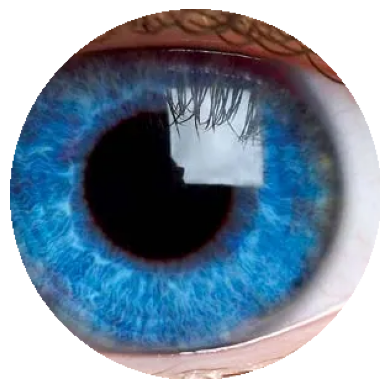

In [108]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

def apply_mask(image_path, output_path):
    # Load image
    img = Image.open(image_path)
    
    # Convert image to numpy array
    img_np = np.array(img)
    
    # Create a new image ('L' mode means each pixel is a single grayscale value)
    mask = Image.new('L', (img_np.shape[1], img_np.shape[0]), 0)
    
    # Get the center and radius of the circle
    y_center, x_center = img_np.shape[0] // 2, img_np.shape[1] // 2
    radius = min(x_center, y_center)
    
    # Draw a white filled circle in the black image
    ImageDraw.Draw(mask).ellipse((x_center-radius, y_center-radius, x_center+radius, y_center+radius), fill=255)

    # Convert mask to numpy array
    mask_np = np.array(mask)
    
    # Convert mask to 3 channels
    mask_rgb = np.stack([mask_np]*3, axis=-1)
    
    # Apply the mask
    masked_img = np.where(mask_rgb==255, img_np, 255) # You can change 255 to 0 if you want to make the background black
    
    # Convert to Image and save
    masked_img_pil = Image.fromarray(np.uint8(masked_img))
    masked_img_pil.save(output_path)
    
    # Display the image in Jupyter notebook
    plt.imshow(masked_img_pil)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

apply_mask(path, 'cropped_and_masked.png')


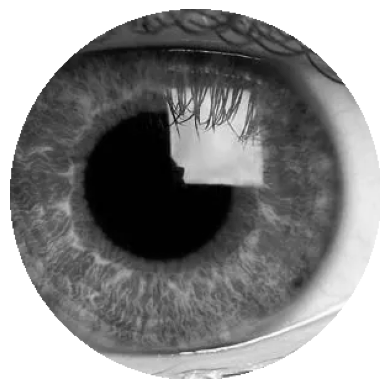

In [109]:
from PIL import Image
import matplotlib.pyplot as plt

def convert_to_grayscale(image_path, output_path):
    # Load image
    img = Image.open(image_path)
    
    # Convert image to grayscale
    grayscale_img = img.convert('L')
    
    # Save the grayscale image
    grayscale_img.save(output_path)
    
    # Display the image in Jupyter notebook
    plt.imshow(grayscale_img, cmap='gray')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

convert_to_grayscale('cropped_and_masked.png', 'cropped_and_masked_gray.png')


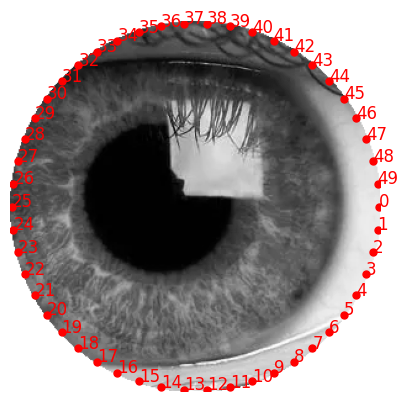

[(299.0, 150.0), (297.82509049585724, 168.67465180108132), (294.318891008166, 187.05479318756335), (288.5366963973495, 204.85055835001702), (280.5696953265357, 221.78129744115557), (270.5435321618672, 237.58000259157848), (258.6163254857903, 251.9975187833746), (244.97617447255476, 264.8064731735926), (229.8381924518705, 275.80486089980025), (213.44111444319583, 284.8192308174369), (196.04353216186718, 291.70742092797786), (177.919815873273, 296.3608003585746), (159.35578740986773, 298.7059825358125), (140.6442125901323, 298.7059825358125), (122.08018412672703, 296.3608003585746), (103.95646783813288, 291.70742092797786), (86.55888555680417, 284.8192308174369), (70.16180754812946, 275.80486089980025), (55.023825527445226, 264.8064731735926), (41.383674514209716, 251.99751878337463), (29.456467838132852, 237.58000259157853), (19.43030467346432, 221.78129744115557), (11.46330360265054, 204.85055835001705), (5.68110899183398, 187.05479318756343), (2.1749095041428177, 168.67465180108138), 

In [110]:
def place_nails(image_path, num_nails):
    # Load the image
    image = Image.open(image_path)
    image = np.array(image)
    
    # Create the figure and axes
    fig, ax = plt.subplots()
    
    # Display the image
    ax.imshow(image, cmap='gray')  # set colormap to gray

    # Calculate the coordinates of the nails
    center_x = image.shape[1] / 2
    center_y = image.shape[0] / 2
    radius = min(center_x, center_y) - 1
    
    # Store the nail coordinates
    nails = []
    
    for i in range(num_nails):
        angle = 2 * np.pi * i / num_nails
        x = center_x + radius * np.cos(angle)
        y = center_y + radius * np.sin(angle)
        
        # Store the nail coordinate
        nails.append((x, y))
        
        # Draw the nail number
        ax.text(x, y, str(i), color='red', fontsize=12)
        
        # Draw the nail position
        ax.plot(x, y, marker='o', markersize=5, color='red')
    
    plt.axis('off')  # hide the axes
    plt.show()
    
    # Return the nail coordinates
    return nails


nails = place_nails('cropped_and_masked_gray.png', num_nails)  # 30 nails for example

print(nails)

In [111]:
def generate_all_lines(nails):
    # Initialize a dictionary to store the lines
    lines = {}

    for i, nail1 in enumerate(nails):
        # Initialize a list to store the lines for this nail
        lines[i] = []

        for j, nail2 in enumerate(nails):
            # Don't generate a line from a nail to itself
            if i != j:
                x1, y1 = nail1
                x2, y2 = nail2

                # Generate the line and store it in the dictionary
                line = bresenham_line(int(x1), int(y1), int(x2), int(y2))
                lines[i].append((j, line))
                
    return lines

lines = generate_all_lines(nails)


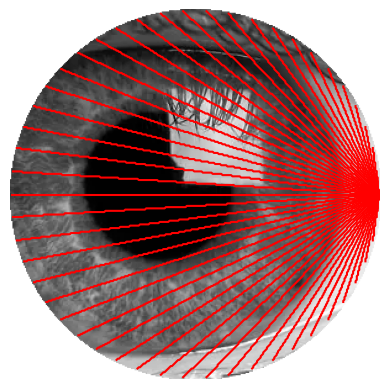

In [112]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def draw_lines_from_nail(nail_number, lines, image_path):
    # Load the image
    image = Image.open(image_path)
    image = np.array(image)

    # Create the figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image, cmap='gray')

    # Get the lines for the specified nail
    nail_lines = lines[nail_number]

    for nail, line in nail_lines:
        # Extract the x and y coordinates of the line
        xs, ys = zip(*[point for point, _ in line])

        # Draw the line
        ax.plot(xs, ys, color='red')

    plt.axis('off')  # hide the axes
    plt.show()

# usage example
draw_lines_from_nail(0, lines, 'cropped_and_masked_gray.png')


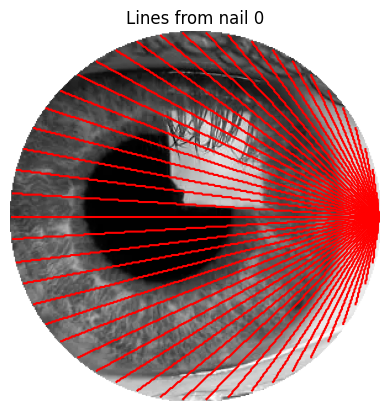

In [113]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Load the image
image = Image.open('cropped_and_masked_gray.png')
image = np.array(image)

# Create the figure and axes
fig, ax = plt.subplots()

# Display the image
im = ax.imshow(image, cmap='gray')

# Get the list of nails
nails2 = list(lines.keys())

# This function will be called for each frame of the animation.
# It will draw the lines from the current nail to all other nails.
def update(frame):
    ax.clear()  # clear the current frame
    ax.imshow(image, cmap='gray')  # redraw the image

    # Get the current nail number
    nail_number = nails2[frame % len(nails2)]

    # Get the lines for the current nail
    nail_lines = lines[nail_number]

    for nail, line in nail_lines:
        # Extract the x and y coordinates of the line
        xs, ys = zip(*[point for point, _ in line])

        # Draw the line
        ax.plot(xs, ys, color='red')

    ax.set_title(f'Lines from nail {nail_number}')  # update the title

    plt.axis('off')  # hide the axes

# Create the animation
ani = FuncAnimation(fig, update, frames=len(nails2), interval=100)  # change interval for speed

ani.save('animation.mp4', writer='ffmpeg')




In [114]:
def sum_darkness(image, lines):
    line_darkness = {}

    for nail, lines_from_nail in lines.items():
        # Initialize a list to store the total darkness for each line
        line_darkness[nail] = []

        for target_nail, line in lines_from_nail:
            # Sum the pixel values for this line
            total_darkness = sum(image[y, x] for (x, y), _ in line)
            line_darkness[nail].append((target_nail, total_darkness))

    return line_darkness

# Load the image
image = Image.open('cropped_and_masked_gray.png')
image = np.array(image)

line_darkness = sum_darkness(image, lines)


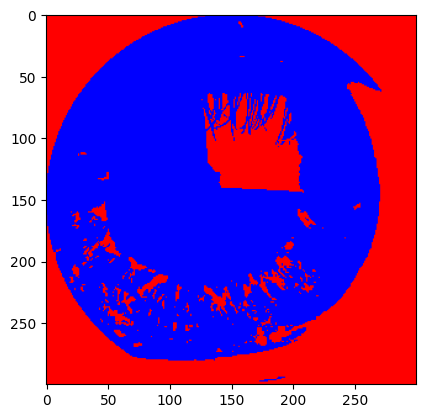

In [115]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the image
image = Image.open('cropped_and_masked_gray.png')
image = np.array(image)

# Create a binary mask
threshold = 128
mask = image > threshold

# Create a new RGB image of the same size
rgb_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

# Set the pixels where the mask is True to red
rgb_image[mask] = [255, 0, 0]  

# Set the pixels where the mask is False to blue
rgb_image[~mask] = [0, 0, 255]  

# Display the image
plt.imshow(rgb_image)
plt.show()


In [116]:
# def find_darkest_target(image, lines_from_nail):
#     # Initialize the darkest nail as the first one and the maximum darkness as 0
#     darkest_target_nail, max_darkness = None, 0

#     for target_nail, line in lines_from_nail:
#         # Sum the pixel values for this line
#         total_darkness = sum(image[y, x] for (x, y), _ in line)
#         # If the total darkness for this nail is greater than the current maximum
#         if total_darkness > max_darkness:
#             # Update the darkest nail and maximum darkness
#             darkest_target_nail, max_darkness = target_nail, total_darkness

#     return darkest_target_nail

# # Let's test the function with nail number 1 for example
# darkest_target = find_darkest_target(image, lines[1])
# print(f"The darkest target from nail 1 is nail {darkest_target}.")

def find_darkest_target(image, lines_from_nail):
    # Initialize the darkest nail as the first one and the maximum darkness as 0
    darkest_target_nail, max_darkness = None, 0

    for target_nail, line in lines_from_nail:
        # Sum the darkness values for this line
        total_darkness = sum(255 - image[y, x] for (x, y), _ in line)
        # If the total darkness for this nail is greater than the current maximum
        if total_darkness > max_darkness:
            # Update the darkest nail and maximum darkness
            darkest_target_nail, max_darkness = target_nail, total_darkness

    return darkest_target_nail

# Let's test the function with nail number 1 for example
darkest_target = find_darkest_target(image, lines[1])
print(f"The darkest target from nail 1 is nail {darkest_target}.")



The darkest target from nail 1 is nail 26.


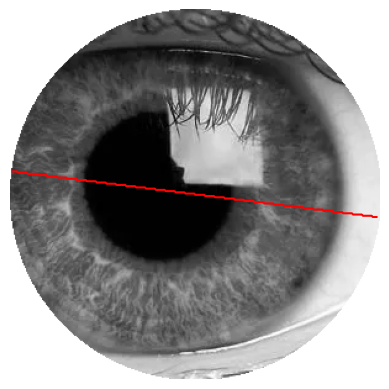

In [117]:
def draw_darkest_line(image_path, lines, nail, target):
    # Load the image
    image = Image.open(image_path)
    image = np.array(image)

    # Create the figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image, cmap='gray')

    # Find the line between the nail and the target
    for target_nail, line in lines[nail]:
        if target_nail == target:
            # If this is the line to the target, draw it
            xs, ys = zip(*[point for point, _ in line])
            ax.plot(xs, ys, 'r')
            break

    plt.axis('off')
    plt.show()

# Find the darkest target from nail 1
darkest_target = find_darkest_target(image, lines[1])

# Draw the line from nail 1 to its darkest target
draw_darkest_line('cropped_and_masked_gray.png', lines, 1, darkest_target)


In [118]:

print(nails)

[(299.0, 150.0), (297.82509049585724, 168.67465180108132), (294.318891008166, 187.05479318756335), (288.5366963973495, 204.85055835001702), (280.5696953265357, 221.78129744115557), (270.5435321618672, 237.58000259157848), (258.6163254857903, 251.9975187833746), (244.97617447255476, 264.8064731735926), (229.8381924518705, 275.80486089980025), (213.44111444319583, 284.8192308174369), (196.04353216186718, 291.70742092797786), (177.919815873273, 296.3608003585746), (159.35578740986773, 298.7059825358125), (140.6442125901323, 298.7059825358125), (122.08018412672703, 296.3608003585746), (103.95646783813288, 291.70742092797786), (86.55888555680417, 284.8192308174369), (70.16180754812946, 275.80486089980025), (55.023825527445226, 264.8064731735926), (41.383674514209716, 251.99751878337463), (29.456467838132852, 237.58000259157853), (19.43030467346432, 221.78129744115557), (11.46330360265054, 204.85055835001705), (5.68110899183398, 187.05479318756343), (2.1749095041428177, 168.67465180108138), 

(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585724, 168.67465180108132)
(297.82509049585

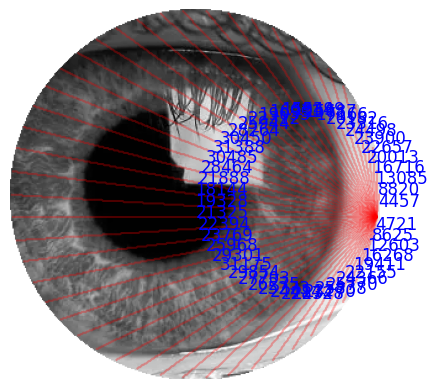

In [119]:
def draw_darkness_values(image_path, lines, line_darkness, nail):
    # Load the image
    image = Image.open(image_path)
    image = np.array(image)

    # Create the figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image, cmap='gray')

    # Draw the lines from the given nail and display the darkness values
    for (target_nail, line), (_, total_darkness) in zip(lines[nail], line_darkness[nail]):
        xs, ys = zip(*[point for point, _ in line])
        ax.plot(xs, ys, 'r', alpha=0.3)

        # Draw the total darkness
        nail_coordinates = nails[nail]
        target_nail_coordinates = nails[target_nail]
        print(nail_coordinates)
        midpoint_x = (nail_coordinates[0] + target_nail_coordinates[0]) / 2
        midpoint_y = (nail_coordinates[1] + target_nail_coordinates[1]) / 2
        ax.text(midpoint_x, midpoint_y, str(total_darkness), color='blue', fontsize=12)

    plt.axis('off')
    plt.show()

# Draw the lines from nail 1 to all other nails and display the darkness values
draw_darkness_values('cropped_and_masked_gray.png', lines, line_darkness, 1)
